In [1]:
# from itertools import product
from tqdm.contrib.itertools import product
import numpy as np
from numpy import load
import pandas as pd
import xarray as xr
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import time

# multiprocessing
# https://superfastpython.com/multiprocessing-for-loop/
from multiprocessing import Process

/bsuhome/zacharykeskinen/miniconda3/envs/spicy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_bootstrap(x, y):
    # bootstrap
    x_bs = np.random.choice(x, size = len(x))
    y_bs = np.random.choice(y, size = len(y))

    return x_bs, y_bs

def calc_rmse(y_actual, y_pred):
    rms = mean_squared_error(y_actual, y_pred, squared = False)
    return rms

In [30]:
# Create parameter space
A = np.round(np.arange(1, 3.1, 0.5), 2)
B = np.round(np.arange(0, 1.01, 0.1), 2)
C = np.round(np.arange(0, 1.001, 0.01), 2)
ABC = [A, B, C]

df = pd.DataFrame(np.ones((3, 4), dtype = float)*10, columns = ['a', 'b', 'c', 'rmse'])

# from itertools import product
from tqdm.contrib.itertools import product
new_param_dir = Path('~/scratch/params_np').expanduser()

for i in range(10):
    low_rmse = 1e10
    best_coords = {'a': None, 'b': None, 'c': None}
    for a, b, c in product(*ABC):
        try:
            data = load(new_param_dir.joinpath(f'{a}_{b}_{c}.npy'))
                
            rmse = calc_rmse(*get_bootstrap(data[0], data[1])) # row 0 = lidar-sd, 1 = spicy
            if rmse < low_rmse:
                low_rmse = rmse
                best_coords['a'] = a
                best_coords['b'] = b
                best_coords['c'] = c
        except FileNotFoundError:
            pass

    # best = rmse_no_flag.where(rmse_no_flag==rmse_no_flag.min(), drop=True).squeeze()
    # a, b, c = best.coords.values()
    df.loc[i, 'a'] = best_coords['a']
    df.loc[i, 'b'] = best_coords['b']
    df.loc[i, 'c'] = best_coords['c']
    df.loc[i, 'rmse'] = float(low_rmse)

100%|██████████| 5555/5555 [00:04<00:00, 1388.23it/s]


<Axes: ylabel='Density'>

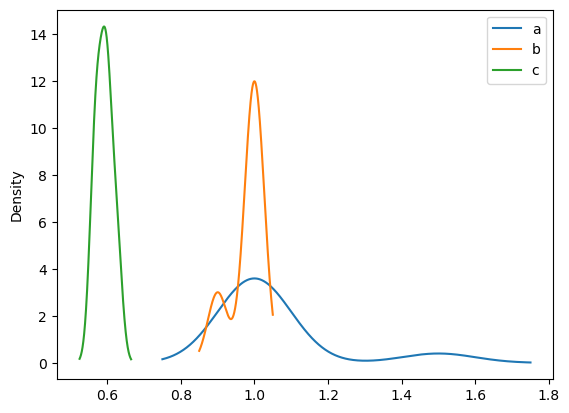

In [55]:
df.drop('rmse', axis = 1).plot.kde()